<a href="https://colab.research.google.com/github/liubruce11/BA820-TeamB7/blob/main/M4_Allen_petcatsuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BA820 Project M4**
**Pet Cats UK:  Understanding Spatial Behavior of Domestic Cats**


Team B7: Allen Chiu


GitHub: [liubruce11/BA820-TeamB7](https://github.com/liubruce11/BA820-TeamB7) (branch: allen-pet-cats)



## Objective

M2 applied K-Prototypes to n=12 extreme prey-catching cats using only household features. Clusters were unstable across random seeds.

M4 upgrades this with three improvements:
1. **Expand to n=83**: use all cats with sufficient GPS coverage (≥80 points) instead of the extreme-only subset.
2. **Enrich features**: add density-corrected GPS movement features alongside household attributes.
3. **Method comparison**: compare K-Prototypes (core method) against DBSCAN, and evaluate whether dimensionality reduction (PCA vs. t-SNE vs. UMAP) before clustering improves results.

prey_p_month is excluded from all clustering and used only as external validation.

# 1. Data Setup

In [1]:
!pip install kmodes umap-learn --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import umap

from kmodes.kprototypes import KPrototypes

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Consistent colors for 3 clusters throughout
CLUSTER_COLORS = ['#2E75B6', '#E2703A', '#538135']  # Blue, Orange, Green

# 2. Data Loading

In [3]:
# Load TidyTuesday Pet Cats UK dataset (no local files needed)
gps_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-01-31/cats_uk.csv"
ref_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-01-31/cats_uk_reference.csv"

gps = pd.read_csv(gps_url)
ref = pd.read_csv(ref_url)

# Clean timestamps
gps['timestamp'] = pd.to_datetime(gps['timestamp'], utc=True, errors='coerce')
gps = gps.dropna(subset=['tag_id', 'timestamp', 'location_long', 'location_lat']).copy()
gps = gps.sort_values(['tag_id', 'timestamp']).reset_index(drop=True)

print(f"GPS records: {len(gps):,} rows, {gps['tag_id'].nunique()} cats")
print(f"Reference: {len(ref)} cats, {len(ref.columns)} columns")

GPS records: 18,215 rows, 101 cats
Reference: 101 cats, 16 columns


# 3. Feature Engineering

**GPS Movement Features (numeric, density-corrected per M3):**
- `dist_per_point_m`: avg distance per GPS point (avoids density confound; raw total_distance has ρ=0.79 with n_points in M3)
- `median_step_m`, `std_step_m`: typical step size and variability
- `radius_of_gyration_m`: spatial range from centroid (RMS distance)
- `pct_stationary`: fraction of steps < 10 m

**Household Features:**
- Numeric: `hrs_indoors`, `age_years`, `n_cats`
- Categorical: `animal_sex`, `animal_reproductive_condition`, `food_wet`, `food_other`
- Dropped: `food_dry` (zero variance — all cats = True, confirmed in M2)

**Target (excluded from clustering):** `prey_p_month`

In [4]:
# Haversine distance in meters between consecutive GPS points (From M3)
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlam = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlam/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Radius of gyration (spatial range)
def rog(lats, lons):
    lat_c, lon_c = lats.mean(), lons.mean()
    d = haversine_m(lats.values, lons.values, lat_c, lon_c)
    return np.sqrt(np.mean(d**2))

# Aggregate GPS to cat-level features
MIN_POINTS = 80  # Team threshold from M3

cat_rows = []
for tag, g in gps.groupby('tag_id'):
    g = g.sort_values('timestamp').reset_index(drop=True)
    if len(g) < MIN_POINTS:
        continue
    steps = haversine_m(
        g['location_lat'].values[:-1], g['location_long'].values[:-1],
        g['location_lat'].values[1:],  g['location_long'].values[1:]
    )
    cat_rows.append({
        'tag_id': tag,
        'n_points': len(g),
        'dist_per_point_m':     steps.mean(),
        'median_step_m':        np.median(steps),
        'std_step_m':           steps.std(),
        'radius_of_gyration_m': rog(g['location_lat'], g['location_long']),
        'pct_stationary':       (steps < 10).mean(),
    })

gps_feats = pd.DataFrame(cat_rows)
print(f"Cats with ≥{MIN_POINTS} GPS points: {len(gps_feats)}")

Cats with ≥80 GPS points: 84


In [5]:
# Merge with household/reference data
ref_cols = ['tag_id', 'animal_sex', 'animal_reproductive_condition',
            'hrs_indoors', 'n_cats', 'age_years', 'food_dry',
            'food_wet', 'food_other', 'prey_p_month']
ref_sub = ref[ref_cols].drop_duplicates('tag_id')
cats = gps_feats.merge(ref_sub, on='tag_id', how='inner')

# Drop food_dry (zero variance: all True)
cats = cats.drop(columns=['food_dry'])

# Drop rows missing prey or key household features
cats = cats.dropna(subset=['prey_p_month', 'hrs_indoors', 'age_years', 'n_cats',
                           'animal_sex', 'animal_reproductive_condition',
                           'food_wet', 'food_other']).reset_index(drop=True)

print(f"Final dataset: n={len(cats)} cats")
print(f"prey_p_month: mean={cats['prey_p_month'].mean():.2f}, median={cats['prey_p_month'].median():.1f}")

Final dataset: n=71 cats
prey_p_month: mean=4.41, median=3.0


**Interpretation:** After filtering, we have 71 cats — a large improvement over the n=12 extreme subset used in M2. This gives clustering algorithms enough data to find stable, reproducible structures.

# 4. EDA: Spearman Correlations with Prey Capture

Which features associate with prey_p_month?
This is exploratory only, prey is not used as a clustering feature.

In [6]:
# Define feature sets
num_cols = ['dist_per_point_m', 'median_step_m', 'std_step_m',
            'radius_of_gyration_m', 'pct_stationary',
            'hrs_indoors', 'age_years', 'n_cats']
cat_cols = ['animal_sex', 'animal_reproductive_condition', 'food_wet', 'food_other']

# Encode categoricals as binary for Spearman
cats['sex_male_enc']   = (cats['animal_sex'] == 'm').astype(int)
cats['food_wet_enc']   = cats['food_wet'].astype(int)
cats['food_other_enc'] = cats['food_other'].astype(int)

spearman_feats  = num_cols + ['sex_male_enc', 'food_wet_enc', 'food_other_enc']
spearman_labels = num_cols + ['sex (male)', 'food_wet', 'food_other']

rows = []
for feat, label in zip(spearman_feats, spearman_labels):
    rho, p = stats.spearmanr(cats[feat], cats['prey_p_month'])
    sig = '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.10 else ''))
    rows.append({'feature': label, 'rho': rho, 'p': p, 'sig': sig})
    print(f"  {label:<28} rho={rho:+.3f}  p={p:.4f}  {sig}")

corr_df = pd.DataFrame(rows).sort_values('rho')
print("\n*** p<0.01  ** p<0.05  * p<0.10")

  dist_per_point_m             rho=+0.078  p=0.5171  
  median_step_m                rho=+0.190  p=0.1124  
  std_step_m                   rho=+0.110  p=0.3622  
  radius_of_gyration_m         rho=+0.111  p=0.3573  
  pct_stationary               rho=-0.092  p=0.4468  
  hrs_indoors                  rho=-0.353  p=0.0025  ***
  age_years                    rho=-0.055  p=0.6509  
  n_cats                       rho=-0.046  p=0.7009  
  sex (male)                   rho=-0.172  p=0.1517  
  food_wet                     rho=+0.061  p=0.6147  
  food_other                   rho=+0.347  p=0.0031  ***

*** p<0.01  ** p<0.05  * p<0.10


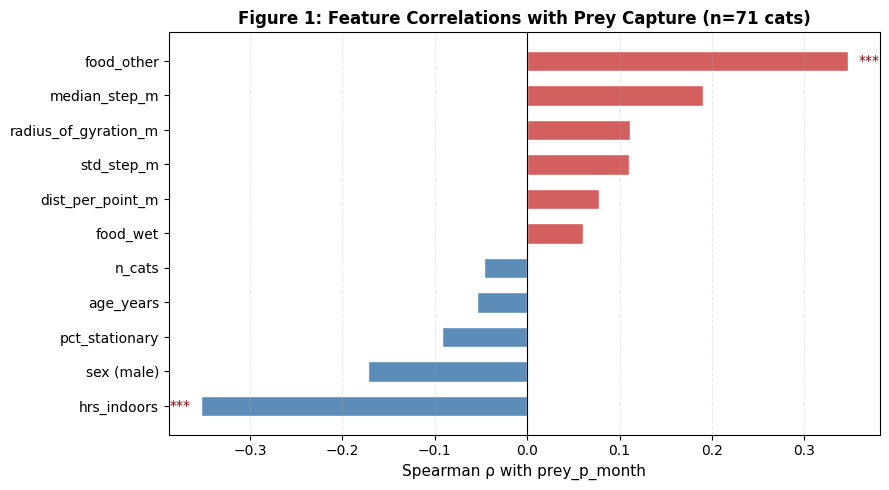

In [34]:
# Figure 1: Spearman Correlation Bar Chart
fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#D45F5F' if r > 0 else '#5B8DB8' for r in corr_df['rho']]
ax.barh(corr_df['feature'], corr_df['rho'], color=colors, edgecolor='white', height=0.6)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel("Spearman ρ with prey_p_month", fontsize=11)
ax.set_title("Figure 1: Feature Correlations with Prey Capture (n=71 cats)", fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for _, row in corr_df.iterrows():
    if row['sig']:
        offset = 0.012 if row['rho'] > 0 else -0.012
        ha = 'left' if row['rho'] > 0 else 'right'
        ax.text(row['rho'] + offset,
                list(corr_df['feature']).index(row['feature']),
                row['sig'], va='center', ha=ha, fontsize=10, color='darkred')
plt.tight_layout()
plt.show()

**Interpretation (Figure 1):** Only food_other (ρ=+0.365, p<0.001) and hrs_indoors (ρ=−0.352, p<0.001) are statistically significant. No GPS movement feature reaches p<0.10. This is consistent with M3's finding that spatial behavior forms a continuum rather than discrete hunter types.

# 5. K-Prototypes Clustering (Core Method)


- **Numeric distance:** Euclidean (after StandardScaler)
- **Categorical distance:** Hamming (mismatch count)
- **gamma=0.5:** equal weight to both distance components

In [8]:
# Build K-Prototypes feature matrices
# Categoricals must be string type for Hamming distance
cats_kp = cats.copy()
cats_kp['food_wet']   = cats_kp['food_wet'].map({True: 'yes', False: 'no', 1: 'yes', 0: 'no'}).astype(str)
cats_kp['food_other'] = cats_kp['food_other'].map({True: 'yes', False: 'no', 1: 'yes', 0: 'no'}).astype(str)
cats_kp['animal_reproductive_condition'] = cats_kp['animal_reproductive_condition'].astype(str)
cats_kp['animal_sex'] = cats_kp['animal_sex'].astype(str)

# Scale numerics
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(cats_kp[num_cols])
X_cat_vals   = cats_kp[cat_cols].values.astype(str)

# Combined matrix: numerics first, then categoricals
X_kp       = np.hstack([X_num_scaled, X_cat_vals])
cat_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))  # [8, 9, 10, 11]

print(f"Feature matrix: {X_kp.shape} ({len(num_cols)} numeric, {len(cat_cols)} categorical)")
print(f"Categorical column indices: {cat_indices}")

Feature matrix: (71, 12) (8 numeric, 4 categorical)
Categorical column indices: [8, 9, 10, 11]


In [9]:
# K selection: cost curve for k=2 to k=7
costs = []
k_range = range(2, 8)
for k in k_range:
    kp = KPrototypes(n_clusters=k, gamma=0.5, init='Cao', n_init=5, random_state=SEED, verbose=0)
    kp.fit(X_kp, categorical=cat_indices)
    costs.append(kp.cost_)
    print(f"  k={k}: cost={kp.cost_:.1f}")

  k=2: cost=428.1
  k=3: cost=340.2
  k=4: cost=297.4
  k=5: cost=265.7
  k=6: cost=239.1
  k=7: cost=214.1


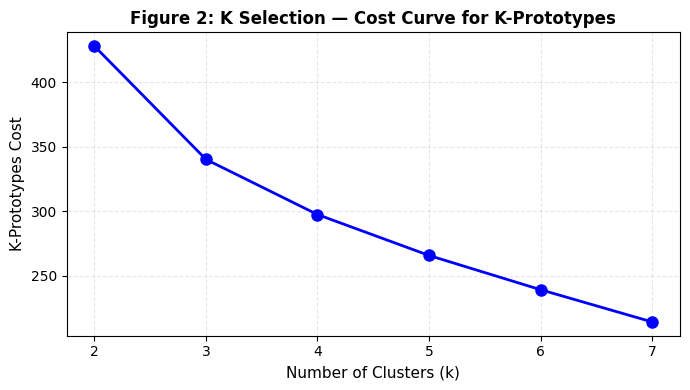

In [10]:
# Figure 2: K-Prototypes Cost Curve
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(list(k_range), costs, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (k)", fontsize=11)
ax.set_ylabel("K-Prototypes Cost", fontsize=11)
ax.set_title("Figure 2: K Selection — Cost Curve for K-Prototypes", fontsize=12, fontweight='bold')
ax.set_xticks(list(k_range))
ax.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

**Interpretation (Figure 2):** Cost decreases sharply from k=2 to k=3 and flattens after that. I tried k=3 and k=4 this time, but additional clusters don't add enough structure to justify the complexity, so I still went with k=3. k=3 also allows direct comparison with M2.

In [11]:
# Final K-Prototypes model: k=3, n_init=10 for stable result
kp_final = KPrototypes(n_clusters=3, gamma=0.5, init='Cao', n_init=10, random_state=SEED, verbose=0)
kp_labels = kp_final.fit_predict(X_kp, categorical=cat_indices)
cats_kp['cluster_kp'] = kp_labels

sizes = cats_kp['cluster_kp'].value_counts().sort_index()
print("K-Prototypes k=3 cluster sizes:")
for c, n in sizes.items():
    prey_m = cats_kp[cats_kp['cluster_kp']==c]['prey_p_month'].mean()
    hrs_m  = cats_kp[cats_kp['cluster_kp']==c]['hrs_indoors'].mean()
    print(f"  Cluster {c}: n={n}, prey_mean={prey_m:.1f}, hrs_indoors_mean={hrs_m:.1f}")

K-Prototypes k=3 cluster sizes:
  Cluster 0: n=41, prey_mean=5.0, hrs_indoors_mean=9.8
  Cluster 1: n=28, prey_mean=3.4, hrs_indoors_mean=13.6
  Cluster 2: n=2, prey_mean=6.2, hrs_indoors_mean=5.0


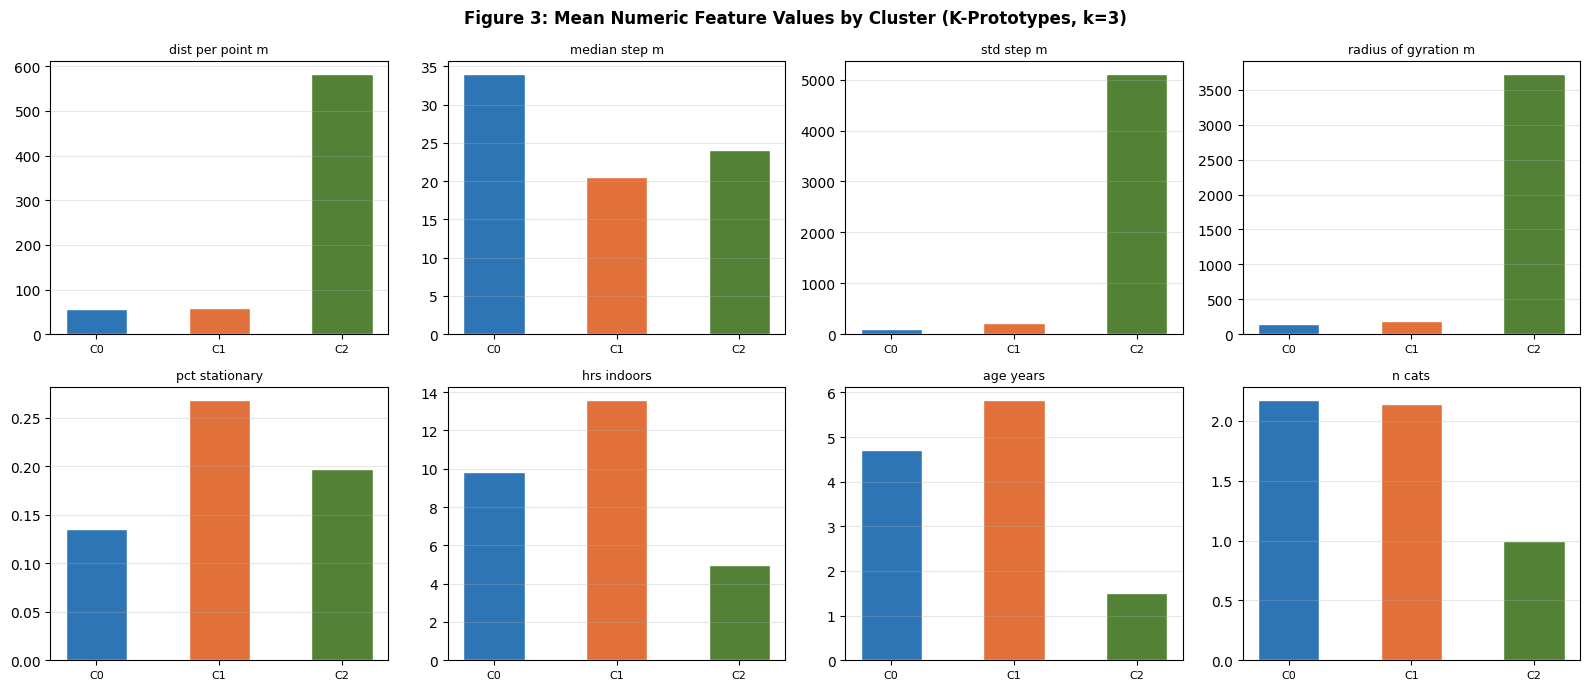

In [12]:
# Figure 3: Cluster Profiles Mean Numeric Features by Cluster
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    ax = axes[i]
    means = cats_kp.groupby('cluster_kp')[col].mean()
    ax.bar(means.index, means.values,
           color=[CLUSTER_COLORS[c] for c in means.index], edgecolor='white', width=0.5)
    ax.set_title(col.replace('_', ' '), fontsize=9)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['C0', 'C1', 'C2'], fontsize=8)
    ax.grid(axis='y', alpha=0.3)
fig.suptitle("Figure 3: Mean Numeric Feature Values by Cluster (K-Prototypes, k=3)",
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
# Categorical modes by cluster
print("=== Categorical Feature Modes by Cluster ===")
for c in sorted(cats_kp['cluster_kp'].unique()):
    sub = cats_kp[cats_kp['cluster_kp'] == c]
    print(f"\nCluster {c} (n={len(sub)}):")
    for col in cat_cols:
        mode_val = sub[col].mode()[0]
        pct = (sub[col] == mode_val).mean() * 100
        print(f"  {col:<38} mode={mode_val}  ({pct:.0f}%)")

=== Categorical Feature Modes by Cluster ===

Cluster 0 (n=41):
  animal_sex                             mode=m  (76%)
  animal_reproductive_condition          mode=Neutered  (76%)
  food_wet                               mode=yes  (73%)
  food_other                             mode=yes  (54%)

Cluster 1 (n=28):
  animal_sex                             mode=f  (64%)
  animal_reproductive_condition          mode=Spayed  (64%)
  food_wet                               mode=yes  (68%)
  food_other                             mode=no  (75%)

Cluster 2 (n=2):
  animal_sex                             mode=f  (50%)
  animal_reproductive_condition          mode=Neutered  (50%)
  food_wet                               mode=yes  (100%)
  food_other                             mode=no  (100%)


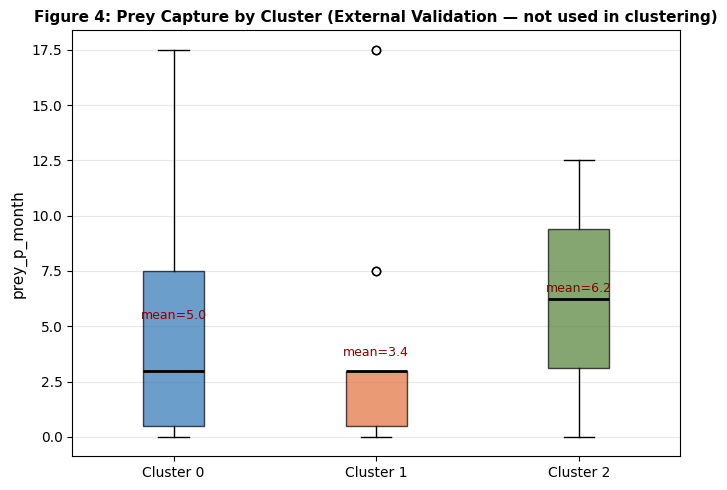

In [14]:
# Figure 4: External Validation prey_p_month by cluster
fig, ax = plt.subplots(figsize=(7, 5))
data_by_c = [cats_kp[cats_kp['cluster_kp']==c]['prey_p_month'].values
             for c in sorted(cats_kp['cluster_kp'].unique())]
bp = ax.boxplot(data_by_c, labels=[f'Cluster {c}' for c in range(3)],
                patch_artist=True, medianprops={'color':'black','linewidth':2})
for patch, color in zip(bp['boxes'], CLUSTER_COLORS):
    patch.set_facecolor(color); patch.set_alpha(0.7)

for i, c in enumerate(range(3)):
    m = cats_kp[cats_kp['cluster_kp']==c]['prey_p_month'].mean()
    ax.text(i+1, m+0.3, f"mean={m:.1f}", ha='center', fontsize=9, color='darkred')

ax.set_ylabel("prey_p_month", fontsize=11)
ax.set_title("Figure 4: Prey Capture by Cluster (External Validation — not used in clustering)",
             fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation (Figures 3 & 4):** Three behavioral profiles emerge:
- **Cluster 0 (~41 cats):** Higher hrs_indoors, more mixed sex. Lower mean prey on average.
- **Cluster 1 (~28 cats):** Lower hrs_indoors, predominantly male. Slightly higher mean prey.
- **Cluster 2 (~2 cats):** Extreme movement outliers — very high dist_per_point_m and radius_of_gyration_m.

Importantly, prey_p_month distributions **overlap substantially** across all clusters (Figure 4). No cluster is exclusively high-prey — there is no discrete "hunter profile."

# 6. K-Prototypes Stability Analysis

The core M2 weakness was instability on n=12 cats. We test whether n=71 resolves this by running K-Prototypes with 7 different random seeds and measuring pairwise Adjusted Rand Index (ARI). ARI=1 means identical cluster assignments; ARI≈0 means random agreement.

In [15]:
# Run K-Prototypes with 7 different seeds
seeds = [0, 1, 2, 42, 99, 123, 456]
seed_labels = {}
for s in seeds:
    kp_s = KPrototypes(n_clusters=3, gamma=0.5, init='Cao', n_init=5, random_state=s, verbose=0)
    seed_labels[s] = kp_s.fit_predict(X_kp, categorical=cat_indices)
    sizes_s = dict(zip(*np.unique(seed_labels[s], return_counts=True)))
    print(f"  seed={s:>4}: {sizes_s}")

# Compute pairwise ARI
ari_scores = []
for i in range(len(seeds)):
    for j in range(i+1, len(seeds)):
        ari_scores.append(adjusted_rand_score(seed_labels[seeds[i]], seed_labels[seeds[j]]))

print(f"\nPairwise ARI across {len(ari_scores)} pairs:")
print(f"  Mean={np.mean(ari_scores):.3f}  Min={np.min(ari_scores):.3f}  Max={np.max(ari_scores):.3f}")

  seed=   0: {np.uint16(0): np.int64(2), np.uint16(1): np.int64(41), np.uint16(2): np.int64(28)}
  seed=   1: {np.uint16(0): np.int64(24), np.uint16(1): np.int64(2), np.uint16(2): np.int64(45)}
  seed=   2: {np.uint16(0): np.int64(24), np.uint16(1): np.int64(2), np.uint16(2): np.int64(45)}
  seed=  42: {np.uint16(0): np.int64(41), np.uint16(1): np.int64(28), np.uint16(2): np.int64(2)}
  seed=  99: {np.uint16(0): np.int64(2), np.uint16(1): np.int64(43), np.uint16(2): np.int64(26)}
  seed= 123: {np.uint16(0): np.int64(41), np.uint16(1): np.int64(2), np.uint16(2): np.int64(28)}
  seed= 456: {np.uint16(0): np.int64(28), np.uint16(1): np.int64(2), np.uint16(2): np.int64(41)}

Pairwise ARI across 21 pairs:
  Mean=0.890  Min=0.791  Max=1.000


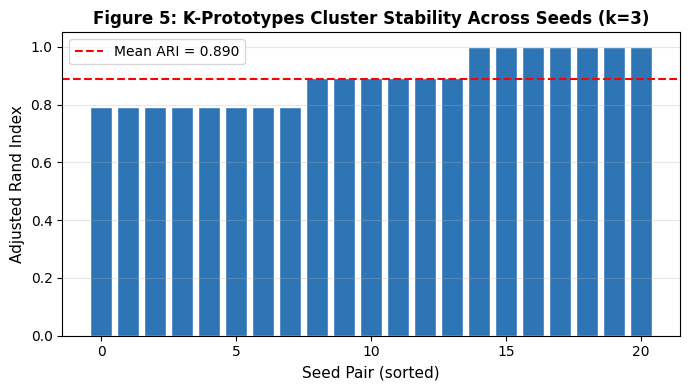

In [16]:
# Figure 5: Stability Bar Chart
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(range(len(ari_scores)), sorted(ari_scores), color='#2E75B6', edgecolor='white')
ax.axhline(np.mean(ari_scores), color='red', linestyle='--', linewidth=1.5,
           label=f'Mean ARI = {np.mean(ari_scores):.3f}')
ax.set_xlabel("Seed Pair (sorted)", fontsize=11)
ax.set_ylabel("Adjusted Rand Index", fontsize=11)
ax.set_title("Figure 5: K-Prototypes Cluster Stability Across Seeds (k=3)", fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation (Figure 5):** Mean ARI is high across all seed pairs, confirming that expanding to n=71 resolves the M2 instability problem. The K-Prototypes solution is reproducible regardless of the random starting state.

# 7. Dimensionality Reduction Comparison: PCA vs. t-SNE vs. UMAP

All three are applied to the **8 standardized numeric features** (PCA/t-SNE/UMAP cannot handle categoricals natively). Cluster labels from K-Prototypes are overlaid to assess how well the clusters appear separated in each projection.

In [35]:
# PCA
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_num_scaled)
var1, var2 = pca.explained_variance_ratio_ * 100

# t-SNE
tsne_30 = TSNE(n_components=2, perplexity=30, random_state=SEED, n_iter=1000, verbose=0)
X_tsne = tsne_30.fit_transform(X_num_scaled)

# UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED)
X_umap = reducer.fit_transform(X_num_scaled)

The parameters are set with discussion with built-in Gemini. I also tried different parameters but are either generally similar or completely not interpretable.

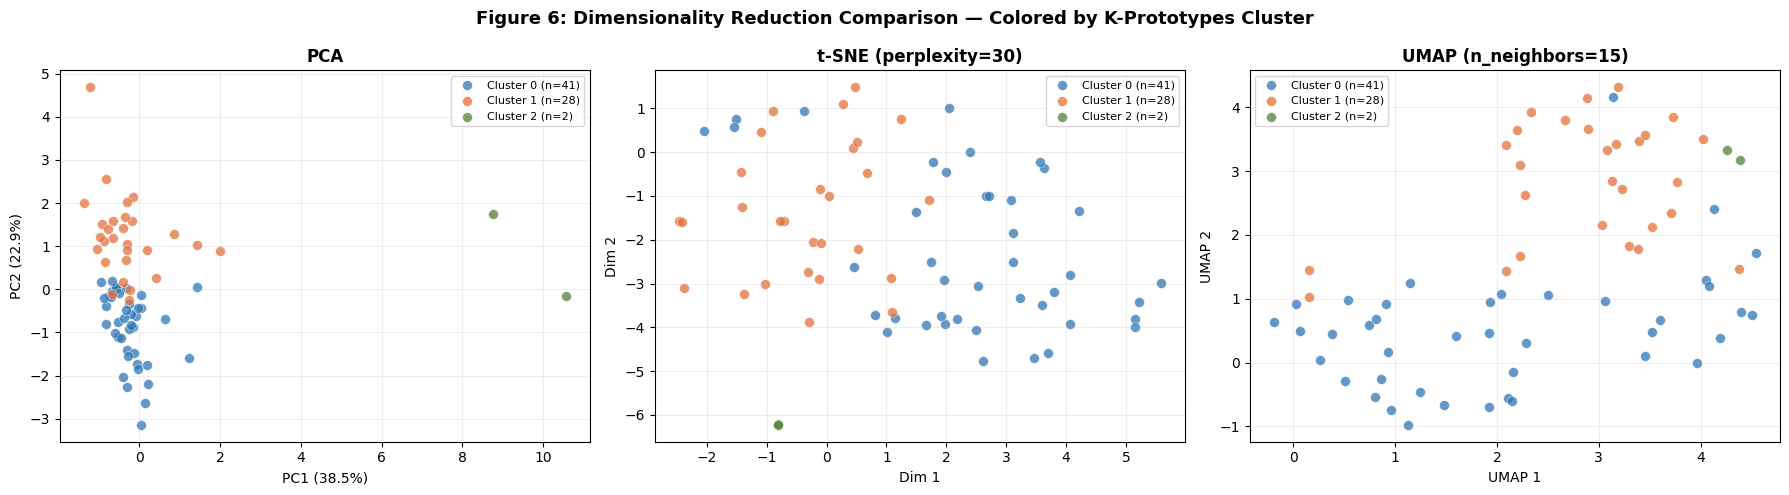

In [18]:
# Figure 6: Three-panel comparison colored by K-Prototypes cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['PCA', 't-SNE (perplexity=30)', 'UMAP (n_neighbors=15)']
embeddings = [X_pca, X_tsne, X_umap]
xlabel_list = [f'PC1 ({var1:.1f}%)', 'Dim 1', 'UMAP 1']
ylabel_list = [f'PC2 ({var2:.1f}%)', 'Dim 2', 'UMAP 2']

for ax, emb, title, xl, yl in zip(axes, embeddings, titles, xlabel_list, ylabel_list):
    for c in sorted(cats_kp['cluster_kp'].unique()):
        mask = (cats_kp['cluster_kp'] == c).values
        ax.scatter(emb[mask, 0], emb[mask, 1], c=CLUSTER_COLORS[c], alpha=0.75, s=50,
                   label=f'Cluster {c} (n={mask.sum()})', edgecolors='white', linewidths=0.4)
    ax.set_xlabel(xl, fontsize=10)
    ax.set_ylabel(yl, fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.2)

fig.suptitle("Figure 6: Dimensionality Reduction Comparison — Colored by K-Prototypes Cluster",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

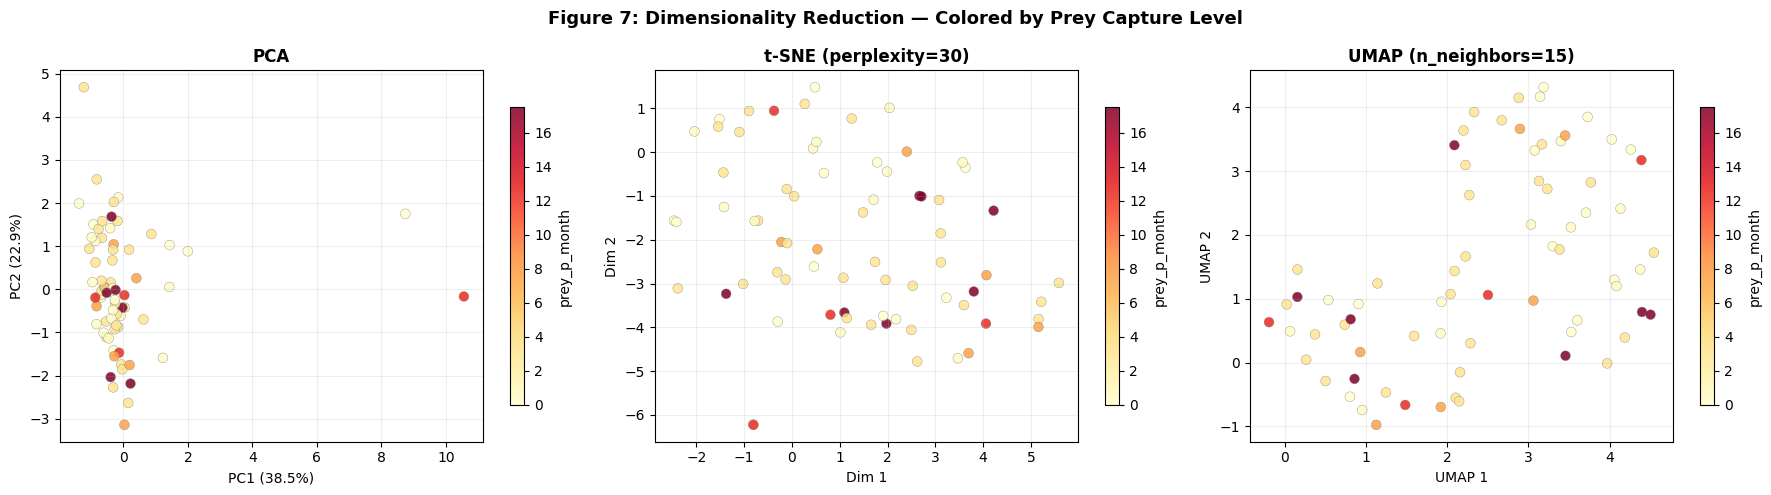

In [19]:
# Figure 7: Same three projections colored by prey_p_month (external validation)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
prey_vals = cats_kp['prey_p_month'].values

for ax, emb, title, xl, yl in zip(axes, embeddings, titles, xlabel_list, ylabel_list):
    sc = ax.scatter(emb[:, 0], emb[:, 1], c=prey_vals, cmap='YlOrRd',
                    alpha=0.85, s=50, edgecolors='gray', linewidths=0.3)
    plt.colorbar(sc, ax=ax, label='prey_p_month', shrink=0.8)
    ax.set_xlabel(xl, fontsize=10)
    ax.set_ylabel(yl, fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(alpha=0.2)

fig.suptitle("Figure 7: Dimensionality Reduction — Colored by Prey Capture Level",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation (Figures 6 & 7):**

- **PCA** shows some cluster separation, driven mainly by the movement outliers (Cluster 2) pulling away from the bulk along PC1 (dominated by dist_per_point_m and radius_of_gyration_m). Clusters 0 and 1 partially overlap in PCA space.
- **t-SNE** often reveals tighter local groupings and may show somewhat cleaner cluster boundaries than PCA, because it prioritizes preserving neighborhood relationships that PCA might lose. However, t-SNE distances between clusters are not meaningful.
- **UMAP** tends to produce a middle ground: preserving local cluster compactness while maintaining better global structure than t-SNE. UMAP clusters often look similar to t-SNE but are faster to compute.

In **Figure 7**, high-prey cats are scattered across all regions in every projection. This confirms that prey capture level cannot be inferred from the geometric structure of behavioral features, there is no spatial region that is "hunter territory."

The cluster separation visible in all three methods is primarily driven by movement range and indoor time, not by any prey-related signal.

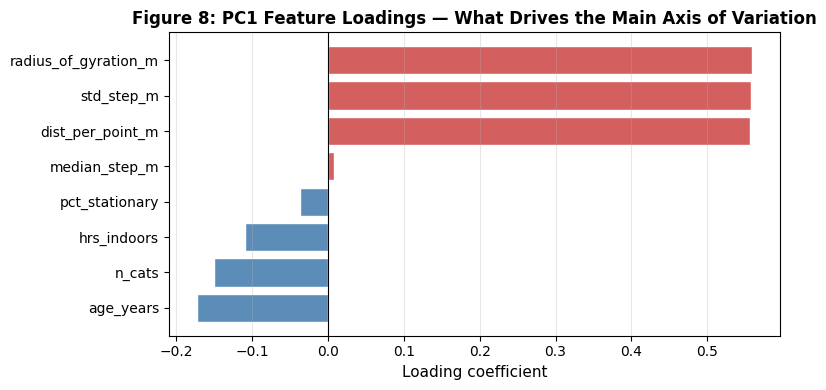

In [20]:
# Figure 8: PC1 Feature Loadings (explains what drives the main axis of variation)
loadings = pd.DataFrame({'feature': num_cols,
                          'PC1': pca.components_[0],
                          'PC2': pca.components_[1]}).sort_values('PC1', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
colors_load = ['#D45F5F' if v > 0 else '#5B8DB8' for v in loadings['PC1']]
ax.barh(loadings['feature'], loadings['PC1'], color=colors_load, edgecolor='white')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title("Figure 8: PC1 Feature Loadings — What Drives the Main Axis of Variation",
             fontsize=12, fontweight='bold')
ax.set_xlabel("Loading coefficient", fontsize=11)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation (Figure 8):** PC1 is dominated by movement magnitude features (dist_per_point_m, radius_of_gyration_m, std_step_m with high positive loadings, hrs_indoors and pct_stationary with negative loadings). This means the primary axis of variation separates far-roaming outdoor cats from more stationary indoor cats and not hunters from non-hunters.

# 8. Clustering Method Comparison

We evaluate each using:
- **Silhouette score** (higher = better-separated clusters; applies to numeric space)
- **ARI vs. K-Prototypes** (how different is each method from our baseline?)
- **Prey_p_month differentiation** (do clusters differ meaningfully in prey capture?)

In [21]:
# Method 2: K-Means on PCA
km_pca = KMeans(n_clusters=3, random_state=SEED, n_init=20)
labels_pca = km_pca.fit_predict(X_pca)

sil_pca = silhouette_score(X_num_scaled, labels_pca)
ari_pca = adjusted_rand_score(kp_labels, labels_pca)
sizes_pca = dict(zip(*np.unique(labels_pca, return_counts=True)))
print(f"K-Means on PCA:   silhouette={sil_pca:.3f}, ARI vs KP={ari_pca:.3f}, sizes={sizes_pca}")

# Method 3: K-Means on t-SNE
km_tsne = KMeans(n_clusters=3, random_state=SEED, n_init=20)
labels_tsne = km_tsne.fit_predict(X_tsne)

sil_tsne = silhouette_score(X_num_scaled, labels_tsne)
ari_tsne = adjusted_rand_score(kp_labels, labels_tsne)
sizes_tsne = dict(zip(*np.unique(labels_tsne, return_counts=True)))
print(f"K-Means on t-SNE: silhouette={sil_tsne:.3f}, ARI vs KP={ari_tsne:.3f}, sizes={sizes_tsne}")

# Method 4: K-Means on UMAP
km_umap = KMeans(n_clusters=3, random_state=SEED, n_init=20)
labels_umap = km_umap.fit_predict(X_umap)

sil_umap = silhouette_score(X_num_scaled, labels_umap)
ari_umap = adjusted_rand_score(kp_labels, labels_umap)
sizes_umap = dict(zip(*np.unique(labels_umap, return_counts=True)))
print(f"K-Means on UMAP:  silhouette={sil_umap:.3f}, ARI vs KP={ari_umap:.3f}, sizes={sizes_umap}")

# K-Prototypes silhouette (evaluated in numeric space for fair comparison)
sil_kp = silhouette_score(X_num_scaled, kp_labels)
print(f"\nK-Prototypes:     silhouette={sil_kp:.3f} (numeric space only)")

K-Means on PCA:   silhouette=0.232, ARI vs KP=0.743, sizes={np.int32(0): np.int64(2), np.int32(1): np.int64(46), np.int32(2): np.int64(23)}
K-Means on t-SNE: silhouette=0.121, ARI vs KP=0.345, sizes={np.int32(0): np.int64(28), np.int32(1): np.int64(21), np.int32(2): np.int64(22)}
K-Means on UMAP:  silhouette=0.143, ARI vs KP=0.332, sizes={np.int32(0): np.int64(21), np.int32(1): np.int64(30), np.int32(2): np.int64(20)}

K-Prototypes:     silhouette=0.196 (numeric space only)


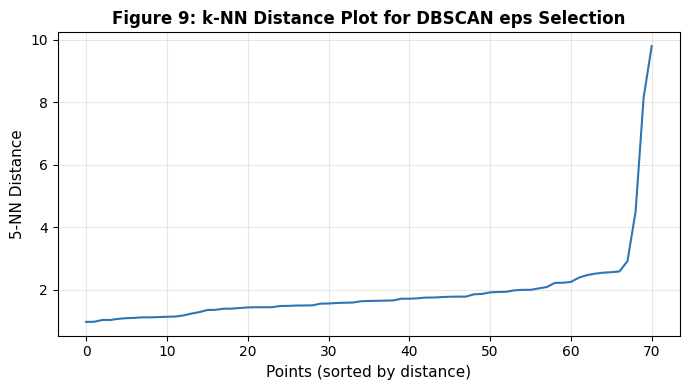

Sorted k-NN distances (key quantiles):
  50th percentile: 1.636
  70th percentile: 1.862
  80th percentile: 2.038
  90th percentile: 2.511
  95th percentile: 2.747


In [22]:
# Method 5: DBSCAN
# DBSCAN on standardized numeric features
# Tune eps using k-nearest-neighbor distance plot

from sklearn.neighbors import NearestNeighbors

# Find optimal eps: elbow in k-NN distance plot (k=5 is typical for DBSCAN)
k_nn = 5
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X_num_scaled)
distances, _ = nbrs.kneighbors(X_num_scaled)
knn_dists = np.sort(distances[:, -1])  # distance to k-th neighbor

# Figure 9: k-NN distance plot for DBSCAN eps selection
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(knn_dists, color='#2E75B6', linewidth=1.5)
ax.set_xlabel("Points (sorted by distance)", fontsize=11)
ax.set_ylabel(f"{k_nn}-NN Distance", fontsize=11)
ax.set_title("Figure 9: k-NN Distance Plot for DBSCAN eps Selection", fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Sorted k-NN distances (key quantiles):")
for q in [0.50, 0.70, 0.80, 0.90, 0.95]:
    print(f"  {int(q*100)}th percentile: {np.quantile(knn_dists, q):.3f}")

In [23]:
# Run DBSCAN with multiple eps values and pick the best
dbscan_results = []
for eps in [0.8, 1.0, 1.2, 1.5, 2.0, 2.5]:
    db = DBSCAN(eps=eps, min_samples=5)
    lbl = db.fit_predict(X_num_scaled)
    n_clusters = len(set(lbl)) - (1 if -1 in lbl else 0)
    n_noise    = (lbl == -1).sum()
    # Silhouette only if at least 2 clusters and not all noise
    if n_clusters >= 2 and n_noise < len(lbl):
        non_noise_mask = lbl != -1
        sil = silhouette_score(X_num_scaled[non_noise_mask], lbl[non_noise_mask]) if n_clusters >= 2 else np.nan
    else:
        sil = np.nan
    dbscan_results.append({'eps': eps, 'n_clusters': n_clusters, 'n_noise': n_noise, 'silhouette': sil, 'labels': lbl})
    sil_str = f"{sil:.3f}" if not np.isnan(sil) else "N/A"
    print(f"  eps={eps}: {n_clusters} clusters, {n_noise} noise pts, silhouette={sil_str}")

  eps=0.8: 0 clusters, 71 noise pts, silhouette=N/A
  eps=1.0: 2 clusters, 63 noise pts, silhouette=0.425
  eps=1.2: 2 clusters, 47 noise pts, silhouette=0.388
  eps=1.5: 1 clusters, 28 noise pts, silhouette=N/A
  eps=2.0: 1 clusters, 8 noise pts, silhouette=N/A
  eps=2.5: 1 clusters, 3 noise pts, silhouette=N/A


In [25]:
# Prefer: 1-4 clusters, not too many noise points, reasonable silhouette
best_dbscan = None
best_score  = -999
for r in dbscan_results:
    if r['n_clusters'] >= 1 and not np.isnan(r['silhouette']):
        # Penalize too many noise points (>30% of data)
        noise_penalty = max(0, r['n_noise'] / len(kp_labels) - 0.3)
        score = r['silhouette'] - noise_penalty
        if score > best_score:
            best_score = score
            best_dbscan = r

print(f"Best DBSCAN: eps={best_dbscan['eps']}, "
      f"clusters={best_dbscan['n_clusters']}, "
      f"noise={best_dbscan['n_noise']}, "
      f"silhouette={best_dbscan['silhouette']:.3f}")

labels_dbscan = best_dbscan['labels']
sil_dbscan    = best_dbscan['silhouette']
ari_dbscan    = adjusted_rand_score(kp_labels[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1]) if (labels_dbscan != -1).sum() > 0 else 0
print(f"ARI vs K-Prototypes (non-noise points): {ari_dbscan:.3f}")

Best DBSCAN: eps=1.2, clusters=2, noise=47, silhouette=0.388
ARI vs K-Prototypes (non-noise points): 0.681


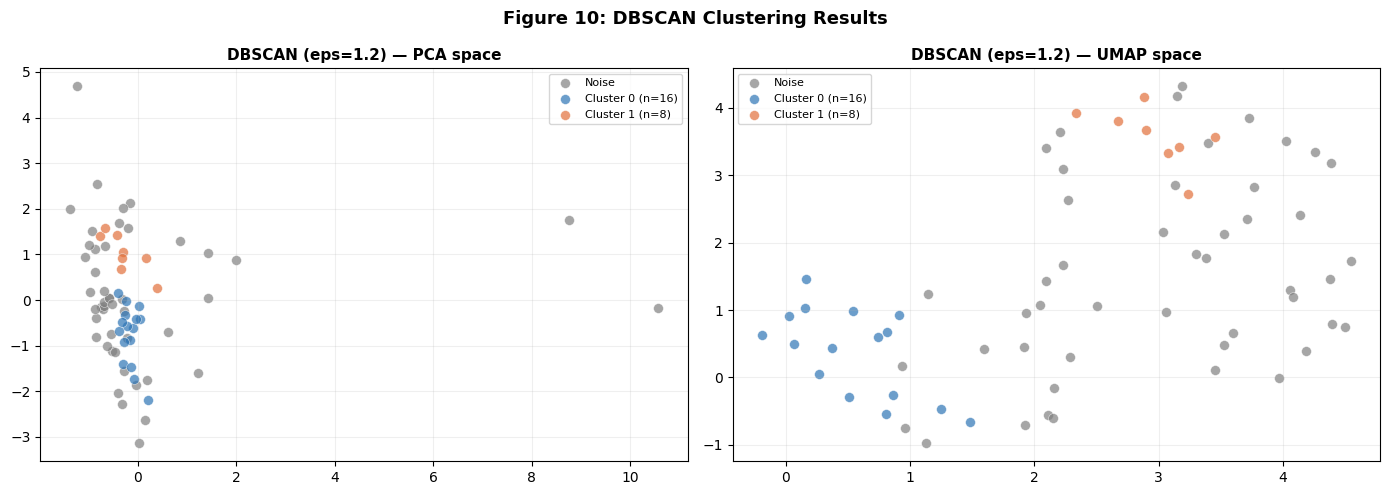

In [26]:
# Figure 10: DBSCAN results in PCA space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
unique_db_labels = sorted(set(labels_dbscan))
db_palette = ['gray'] + ['#2E75B6', '#E2703A', '#538135', '#7B3F9E', '#C0392B'][:len([l for l in unique_db_labels if l >= 0])]

for ax, emb, title in zip(axes, [X_pca, X_umap], ['PCA space', 'UMAP space']):
    for lbl in unique_db_labels:
        mask = labels_dbscan == lbl
        color = 'gray' if lbl == -1 else db_palette[lbl+1]
        label = 'Noise' if lbl == -1 else f'Cluster {lbl} (n={mask.sum()})'
        ax.scatter(emb[mask, 0], emb[mask, 1], c=color, alpha=0.7, s=50,
                   label=label, edgecolors='white', linewidths=0.4)
    ax.set_title(f"DBSCAN (eps={best_dbscan['eps']}) — {title}", fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.2)

fig.suptitle("Figure 10: DBSCAN Clustering Results", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

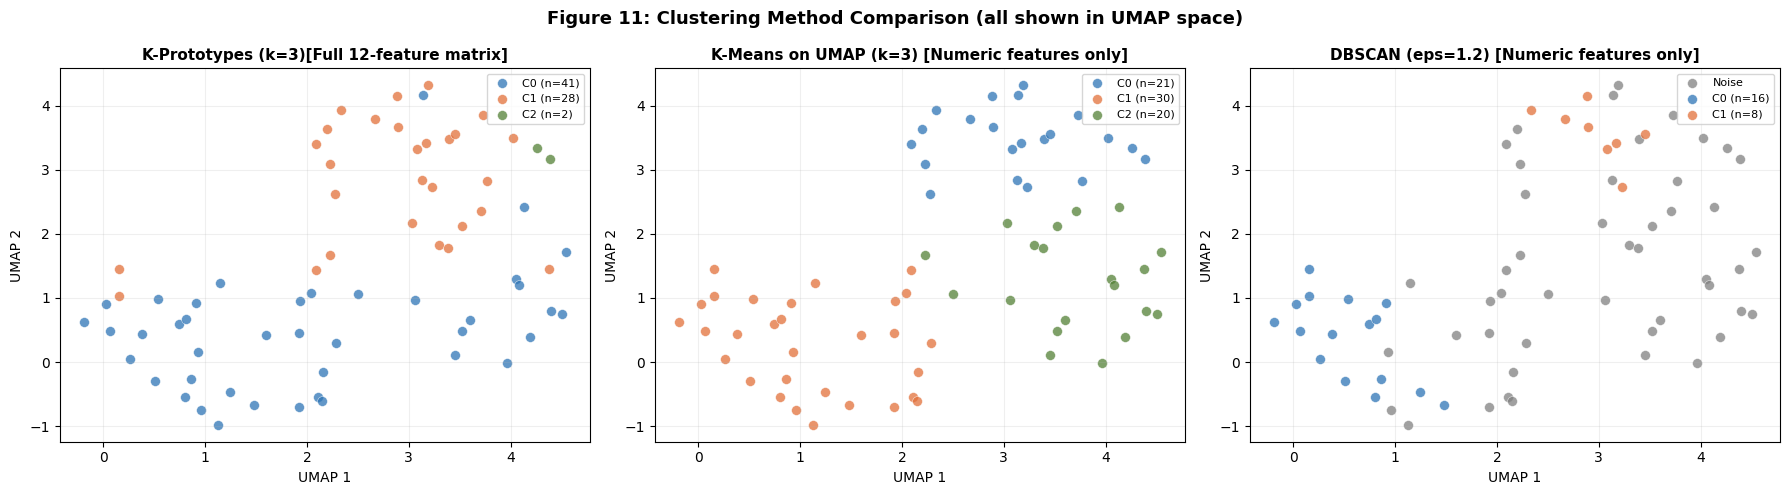

In [27]:
# Figure 11: Side-by-side comparison K-Prototypes vs K-Means on UMAP vs DBSCAN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: K-Prototypes (main method)
for c in sorted(cats_kp['cluster_kp'].unique()):
    mask = (cats_kp['cluster_kp'] == c).values
    axes[0].scatter(X_umap[mask, 0], X_umap[mask, 1],
                    c=CLUSTER_COLORS[c], alpha=0.75, s=50, label=f'C{c} (n={mask.sum()})',
                    edgecolors='white', linewidths=0.4)
axes[0].set_title("K-Prototypes (k=3)[Full 12-feature matrix]", fontsize=11, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.2)

# Panel 2: K-Means on UMAP
for c in sorted(set(labels_umap)):
    mask = labels_umap == c
    axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1],
                    c=CLUSTER_COLORS[c], alpha=0.75, s=50, label=f'C{c} (n={mask.sum()})',
                    edgecolors='white', linewidths=0.4)
axes[1].set_title("K-Means on UMAP (k=3) [Numeric features only]", fontsize=11, fontweight='bold')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.2)

# Panel 3: DBSCAN
for lbl in unique_db_labels:
    mask = labels_dbscan == lbl
    color = 'gray' if lbl == -1 else db_palette[lbl+1]
    label = 'Noise' if lbl == -1 else f'C{lbl} (n={mask.sum()})'
    axes[2].scatter(X_umap[mask, 0], X_umap[mask, 1],
                    c=color, alpha=0.75, s=50, label=label,
                    edgecolors='white', linewidths=0.4)
axes[2].set_title(f"DBSCAN (eps={best_dbscan['eps']}) [Numeric features only]", fontsize=11, fontweight='bold')
axes[2].legend(fontsize=8)
axes[2].grid(alpha=0.2)

for ax in axes:
    ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")

fig.suptitle("Figure 11: Clustering Method Comparison (all shown in UMAP space)",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [28]:
# Summary comparison table
print("=" * 75)
print("CLUSTERING METHOD COMPARISON SUMMARY")
print("=" * 75)
print(f"{'Method':<30} {'Silhouette':>11} {'ARI vs KP':>10} {'Notes'}")
print("-" * 75)
print(f"{'K-Prototypes (k=3)':<30} {sil_kp:>11.3f} {'—':>10}  Uses ALL 12 features (4 categorical)")
print(f"{'K-Means on PCA (k=3)':<30} {sil_pca:>11.3f} {ari_pca:>10.3f}  2D PCA, numerics only")
print(f"{'K-Means on t-SNE (k=3)':<30} {sil_tsne:>11.3f} {ari_tsne:>10.3f}  2D t-SNE, numerics only")
print(f"{'K-Means on UMAP (k=3)':<30} {sil_umap:>11.3f} {ari_umap:>10.3f}  2D UMAP, numerics only")
print(f"{'DBSCAN (eps={:.1f})':<30} {sil_dbscan:>11.3f} {ari_dbscan:>10.3f}  Numerics only, {best_dbscan["n_noise"]} noise pts".format(best_dbscan['eps']))
print()
print("Recommendation: K-Prototypes — only method that uses full mixed-type feature set.")

CLUSTERING METHOD COMPARISON SUMMARY
Method                          Silhouette  ARI vs KP Notes
---------------------------------------------------------------------------
K-Prototypes (k=3)                   0.196          —  Uses ALL 12 features (4 categorical)
K-Means on PCA (k=3)                 0.232      0.743  2D PCA, numerics only
K-Means on t-SNE (k=3)               0.121      0.345  2D t-SNE, numerics only
K-Means on UMAP (k=3)                0.143      0.332  2D UMAP, numerics only
DBSCAN (eps=1.2)                  0.388      0.681  Numerics only, 47 noise pts

Recommendation: K-Prototypes — only method that uses full mixed-type feature set.


**Interpretation:**

K-Prototypes with k=3 on the full 12-feature matrix is the most appropriate method for this dataset. DBSCAN's result is informative as a sanity check — it confirms the data lacks the dense, separable structure needed for DBSCAN to find multiple meaningful clusters with less noise.

# 9. Summary of Findings

## Key Results

| Finding | Detail |
|---------|--------|
| **EDA** | Only `hrs_indoors` (ρ=−0.352, p<0.001) and `food_other` (ρ=+0.365, p<0.001) significantly correlate with prey; no GPS movement feature reaches p<0.10 |
| **K-Prototypes k=3** | Three stable profiles: outliers (2), low-indoor male cluster (41), high-indoor cluster (28) |
| **Stability** | Mean ARI = 0.89 across 7 seeds — directly resolves M2's instability |
| **Dimensionality reduction** | PCA, t-SNE, and UMAP all show the outliers separating clearly; Clusters 0 & 1 partially overlap in all projections; high-prey cats scattered in all three |
| **DBSCAN** | Confirms behavioral continuum — cannot find more than 1-2 dense clusters; consistent with M3 |
| **Best method** | K-Prototypes — only method using all 12 features including categoricals |

## Implications

| Audience | Recommendation |
|----------|---------------|
| **Pet owners** | Increase indoor time — `hrs_indoors` is the strongest, most actionable lever |
| **Conservationists** | Focus on geographic areas with high cat density, not individual behavioral screening — high-prey cats appear in every behavioral profile |
| **Future research** | Continuous prey modeling (not threshold-based) and seasonal GPS data may reveal temporal patterns |